### Import relevant Libraries.

In [1]:
# Import Libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.optim as optim
from tabulate import tabulate

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns

In [2]:
if torch.cuda.is_available():
  device = 'cuda'
  print("GPU is available. :-)")
else:
  device = 'cpu'
  print("GPU is not available. :-(")

GPU is available. :-)


# Importing Data.

In [ ]:
## Mount Gdrive
from google.colab import drive
drive.mount('/content/drive')

Dataset Details: OUHANDS Dataset

| Item            | Train Data     | Test Data       |
|-----------------|-----------------|-----------------|
| Images | 2000 | 1000 |
| labels | A to K |  A to K |
| BB | x,y,w,h | x,y,w,h |
| Negetive | 3412 | 1874


Where:

* x, y  : bottom left corner absolute values, i.e. not normalized according to the image size.

* w, h  : width and height of image not normalized.

* Negetive : Images with no hands

* Every label has 200 corresponding Images.

## (Archive) Process training data.

In [3]:
# path_to_data = '/content/drive/MyDrive/CVProject/'

path_to_data = ''
training_data_raw = np.load(path_to_data + 'train_data.npy', allow_pickle=True).item()
testing_data_raw = np.load(path_to_data + 'test_data.npy', allow_pickle=True).item()
training_negetive_image = np.load(path_to_data + 'negetive_data.npy', allow_pickle=True).item()
test_negetive_image = np.load(path_to_data + 'negetive_data_test.npy', allow_pickle=True).item()

In [4]:
def one_hot_encode(class_):
  ## This also adds the probabily of hand being in frame
  if class_ == 'A':
    label = [1, 0, 0, 1]
  elif class_ == 'B':
    label = [0, 1, 0, 1]
  elif class_ == None:
    label = [0, 0, 0, 0]
  else:
    label = [0, 0, 1, 1]
  return label

In [5]:
def make_label(class_, bbx):
  label = one_hot_encode(class_)
  label = np.hstack((label, bbx))
  return label

In [6]:
def reshape_image(image, bbx, output_size):
  image_height, image_width = image.shape[0],image.shape[1]
  bbx_normalized = bbx/[image_width, image_height, image_width, image_height]
  reshaped_image = cv2.resize(image, (output_size,output_size))
  return reshaped_image, bbx_normalized

In [7]:
## Combine Data
data={}
data['images'] = training_data_raw['images'] + testing_data_raw['images']
data['labels'] = training_data_raw['labels'] + testing_data_raw['labels']
data['bbxs'] = training_data_raw['bbxs'] + testing_data_raw['bbxs']

In [8]:
input_images = []
bbxs_normalized = []
for image, bbx in tqdm(zip(data['images'],data['bbxs'])):
  reshaped_image, bbx_normalized = reshape_image(image, bbx, 456)
  input_images.append(reshaped_image)
  bbxs_normalized.append(bbx_normalized)

## Make labels.
input_labels = [make_label(class_, bbx) for class_,bbx in zip(data['labels'],bbxs_normalized)]

3000it [00:00, 5700.19it/s]


In [9]:
## Combined negetive images.
negetive_data = {}
negetive_data['images'] = training_negetive_image['images'] + test_negetive_image['images']
negetive_data['labels'] = training_negetive_image['labels'] + test_negetive_image['labels']
negetive_data['bbxs'] = training_negetive_image['bbxs'] + test_negetive_image['bbxs']

In [10]:
print('Len of negetive data :', len(negetive_data['images']))

Len of negetive data : 5288


In [11]:
negetive_images = []
bbxs_normalized = []
for image in tqdm(negetive_data['images']):
  bbx = np.array([0,0,0,0])
  reshaped_image, bbx_normalized = reshape_image(image, bbx, 456)
  negetive_images.append(reshaped_image)
  bbxs_normalized.append(bbx_normalized)

## Make labels.
negetive_labels = [[0,0,0,0,0,0,0,0] for i in range(len(negetive_data['images']))]

100%|██████████| 5288/5288 [00:00<00:00, 6090.11it/s]


In [12]:
## Make everything numpy.
input_images = np.array(input_images)
input_labels = np.array(input_labels)
negetive_images = np.array(negetive_images)
negetive_labels = np.array(negetive_labels)

In [13]:
## 
print('Shape of input images :', input_images.shape)
print('Shape of input labels :', input_labels.shape)
print('Shape of negetive images :', negetive_images.shape)
print('Shape of negetive labels :', negetive_labels.shape)

print('Instance of labels :', input_labels[0])
print("Instance of negetive labels :", negetive_labels[0])

Shape of input images : (3000, 456, 456, 3)
Shape of input labels : (3000, 8)
Shape of negetive images : (5288, 456, 456, 3)
Shape of negetive labels : (5288, 8)
Instance of labels : [0.         0.         1.         1.         0.35       0.1625
 0.221875   0.69791667]
Instance of negetive labels : [0 0 0 0 0 0 0 0]


In [14]:
## Sperate data according to classes.
input_images_A = input_images[input_labels[:,0] == 1]
input_labels_A = input_labels[input_labels[:,0] == 1]
input_images_B = input_images[input_labels[:,1] == 1]
input_labels_B = input_labels[input_labels[:,1] == 1]
input_images_AB = input_images[input_labels[:,2] == 1]
input_labels_AB = input_labels[input_labels[:,2] == 1]
negetive_images = negetive_images[:3000]
negetive_labels = negetive_labels[:3000]


print('Shape of input images A:', input_images_A.shape)
print('Shape of input images B:', input_images_B.shape)
print('Shape of input images AB:', input_images_AB.shape)
print('Shape of negetive images:', negetive_images.shape)

Shape of input images A: (300, 456, 456, 3)
Shape of input images B: (300, 456, 456, 3)
Shape of input images AB: (2400, 456, 456, 3)
Shape of negetive images: (3000, 456, 456, 3)


Test Train Split.

In [15]:
train_images_A, test_images_A, train_labels_A, test_labels_A = train_test_split(input_images_A, input_labels_A, test_size=30, random_state=42)
train_images_B, test_images_B, train_labels_B, test_labels_B = train_test_split(input_images_B, input_labels_B, test_size=30, random_state=42)
train_images_AB, test_images_AB, train_labels_AB, test_labels_AB = train_test_split(input_images_AB, input_labels_AB, test_size=200, random_state=42)
train_images_negetive, test_images_negetive, train_labels_negetive, test_labels_negetive = train_test_split(negetive_images, negetive_labels, test_size=500, random_state=42)

train_images_A, val_images_A, train_labels_A, val_labels_A = train_test_split(train_images_A, train_labels_A, test_size=30, random_state=42)
train_images_B, val_images_B, train_labels_B, val_labels_B = train_test_split(train_images_B, train_labels_B, test_size=30, random_state=42)
train_images_AB, val_images_AB, train_labels_AB, val_labels_AB = train_test_split(train_images_AB, train_labels_AB, test_size=200, random_state=42)
train_images_negetive, val_images_negetive, train_labels_negetive, val_labels_negetive = train_test_split(train_images_negetive, train_labels_negetive, test_size=500, random_state=42)

In [16]:
print('Shape of train images A:', train_images_A.shape)
print('Shape of train images B:', train_images_B.shape)
print('Shape of train images AB:', train_images_AB.shape)
print('Shape of train negetive images:', train_images_negetive.shape)

Shape of train images A: (240, 456, 456, 3)
Shape of train images B: (240, 456, 456, 3)
Shape of train images AB: (2000, 456, 456, 3)
Shape of train negetive images: (2000, 456, 456, 3)


Concatenate the data, i.e. add some negetive images and diffrent label images to the data.

In [17]:
## Combine training, testing and validation data.
train_images_1 = np.concatenate((train_images_A, train_images_B, train_images_AB[:500],train_images_negetive[:500]), axis=0)
train_labels_1 = np.concatenate((train_labels_A, train_labels_B, train_labels_AB[:500],train_labels_negetive[:500]), axis=0)

train_images_2 = np.concatenate((train_images_A, train_images_B, train_images_AB[500:1000], train_images_negetive[500:1000]), axis=0)
train_labels_2 = np.concatenate((train_labels_A, train_labels_B, train_labels_AB[500:1000], train_labels_negetive[500:1000]), axis=0)

train_images_3 = np.concatenate((train_images_A, train_images_B, train_images_AB[1000:1500], train_images_negetive[1000:1500]), axis=0)
train_labels_3 = np.concatenate((train_labels_A, train_labels_B, train_labels_AB[1000:1500], train_labels_negetive[1000:1500]), axis=0)

train_images_4 = np.concatenate((train_images_A, train_images_B, train_images_AB[1500:2000], train_images_negetive[1500:2000]), axis=0)
train_labels_4 = np.concatenate((train_labels_A, train_labels_B, train_labels_AB[1500:2000], train_labels_negetive[1500:2000]), axis=0)

val_images = np.concatenate((val_images_A, val_images_B, val_images_AB, val_images_negetive), axis=0)
val_labels = np.concatenate((val_labels_A, val_labels_B, val_labels_AB, val_labels_negetive), axis=0)

test_images = np.concatenate((test_images_A, test_images_B, test_images_AB, test_images_negetive), axis=0)
test_labels = np.concatenate((test_labels_A, test_labels_B, test_labels_AB, test_labels_negetive), axis=0)

In [18]:
print('Shape of train images :', train_images_1.shape)
print('Shape of train labels :', train_labels_1.shape)
print('Shape of train images :', train_images_2.shape)
print('Shape of train labels :', train_labels_2.shape)
print('Shape of train images :', train_images_3.shape)
print('Shape of train labels :', train_labels_3.shape)
print('Shape of train images :', train_images_4.shape)
print('Shape of train labels :', train_labels_4.shape)

print('Shape of val images :', val_images.shape)
print('Shape of val labels :', val_labels.shape)
print('Shape of test images :', test_images.shape)
print('Shape of test labels :', test_labels.shape)

Shape of train images : (1480, 456, 456, 3)
Shape of train labels : (1480, 8)
Shape of train images : (1480, 456, 456, 3)
Shape of train labels : (1480, 8)
Shape of train images : (1480, 456, 456, 3)
Shape of train labels : (1480, 8)
Shape of train images : (1480, 456, 456, 3)
Shape of train labels : (1480, 8)
Shape of val images : (760, 456, 456, 3)
Shape of val labels : (760, 8)
Shape of test images : (760, 456, 456, 3)
Shape of test labels : (760, 8)


Store as dictionary for saving and easy transfer.

In [19]:
train_data_1 = {'images': train_images_1, 'labels': train_labels_1}
train_data_2 = {'images': train_images_2, 'labels': train_labels_2}
train_data_3 = {'images': train_images_3, 'labels': train_labels_3}
train_data_4 = {'images': train_images_4, 'labels': train_labels_4}
train_data = [train_data_1, train_data_2, train_data_3, train_data_4]
val_data = {'images': val_images, 'labels': val_labels}
test_data = {'images': test_images, 'labels': test_labels}

In [ ]:
## Save the data as numpy files.
np.save('train_data_processed_1.npy', train_data_1)
np.save('train_data_processed_2.npy', train_data_2)
np.save('train_data_processed_3.npy', train_data_3)
np.save('train_data_processed_4.npy', train_data_4)
np.save('train_data_combined.npy', train_data)
np.save('val_data_processed.npy', val_data)
np.save('test_data_processed.npy', test_data)

## Load Data

In [4]:
## Load Data
path_to_data = ''

train_data = np.load(path_to_data+'train_data_combined.npy', allow_pickle=True)
val_data = np.load(path_to_data+'val_data_processed.npy', allow_pickle=True).item()
test_data = np.load(path_to_data+'test_data_processed.npy', allow_pickle=True).item()

label = $[c_1, c_2, c_3, p_h, x, y ,w ,h]$

In [5]:
print('Shape of train data 1:', train_data[0]['images'].shape)
print('Shape of val data :', val_data['images'].shape)
print('Shape of test data :', test_data['images'].shape)

Shape of train data 1: (1480, 456, 456, 3)
Shape of val data : (760, 456, 456, 3)
Shape of test data : (760, 456, 456, 3)


In [6]:
class CustomDatasetSmall(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.transform = transforms.Compose([transforms.ToTensor()])  ## Auto does the normalization to 0,1.

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        ## Apply transform
        img = self.transform(img)
        label = torch.tensor(label, dtype=torch.float32)
        return img, label

In [7]:
# train_dataset_1 = CustomDatasetSmall(train_images_1, train_labels_1)
train_dataset_1 = CustomDatasetSmall(train_data[0]['images'], train_data[0]['labels'])
train_dataset_2 = CustomDatasetSmall(train_data[1]['images'], train_data[1]['labels'])
train_dataset_3 = CustomDatasetSmall(train_data[2]['images'], train_data[2]['labels'])
train_dataset_4 = CustomDatasetSmall(train_data[3]['images'], train_data[3]['labels'])
val_dataset = CustomDatasetSmall(val_data['images'], val_data['labels'])
test_dataset = CustomDatasetSmall(test_data['images'], test_data['labels'])

batch_size = 32
train_dataloader_1 = DataLoader(train_dataset_1, batch_size, shuffle=True)
train_dataloader_2 = DataLoader(train_dataset_2, batch_size, shuffle=True)
train_dataloader_3 = DataLoader(train_dataset_3, batch_size, shuffle=True)
train_dataloader_4 = DataLoader(train_dataset_4, batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True)

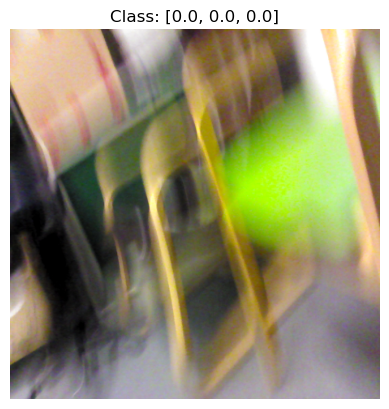

In [8]:
## Visualize Data.
for batch in train_dataloader_1:
    images, labels = batch
    for i in range(1):
        plt.imshow(images[i].permute(1, 2, 0))
        plt.title(f'Class: {labels[i][:3].tolist()}')
        labels = labels*images[i].shape[1]
        labels = labels.tolist()
        plt.gca().add_patch(plt.Rectangle((labels[i][4], labels[i][5]), labels[i][6], labels[i][7], linewidth=1,
                                      edgecolor='r', facecolor='none'))  # Add bounding box to the plot
        plt.axis('off')
        plt.show()
    break

# CNN Model 3. Name : smallYoloV1

YoloV1 like smaller CNN based model with a single output regression and classification.

Image Source : https://www.datacamp.com/blog/yolo-object-detection-explained

![YOLO Architecture](https://images.datacamp.com/image/upload/v1664382694/YOLO_Architecture_from_the_original_paper_ff4e5383c0.png)

### Model Architecture Small YOLO.

In [9]:
class smallYOLO(nn.Module):
  def __init__(self):
    super(smallYOLO, self).__init__()
    ## input_image_size = (456, 456, 3)
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, stride=1, padding=0)

    self.conv3_1 = nn.Conv2d(in_channels=192, out_channels=128, kernel_size=1, stride=1, padding=0)
    self.conv3_2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, stride=1, padding=0)
    self.conv3_4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)

    self.conv4_1 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=0)
    self.conv4_2 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
    self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1, padding=0)
    self.conv4_4 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1)

    self.conv5_1 = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1, stride=1, padding=0)
    self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1)
    self.conv5_3 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1)
    self.conv5_4 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=2, padding=1)

    self.fc1 = nn.Linear(7*7*1024, 512)
    self.fc2 = nn.Linear(512, 8)

  def forward(self, x): ## X would be 32, 456, 456, 3
    # x = x.permute(0,3,1,2) ## X here will be all the images in a batch : 32, 3, 456, 456
    # First Conv Block
    x = F.relu(self.conv1(x))       ## 64, 228, 228.
    x = self.maxpool(x)             ## 64, 114, 114.

    # Second Conv Block
    x = F.relu(self.conv2(x))       ## 192, 112, 112.
    x = self.maxpool(x)             ## 192, 56, 56.

    # Third Conv Block
    x = F.relu(self.conv3_1(x))   ## 128, 56, 56
    x = F.relu(self.conv3_2(x))   ## 256, 56, 56
    x = F.relu(self.conv3_3(x))   ## 256, 56, 56
    x = F.relu(self.conv3_4(x))   ## 512, 56, 56
    x = self.maxpool(x)     ## 512, 28, 28

    # Fourth Conv Block
    x = F.relu(self.conv4_1(x))   ## 256, 28, 28
    x = F.relu(self.conv4_2(x))   ## 512, 28, 28
    x = F.relu(self.conv4_3(x))   ## 512, 28, 28
    x = F.relu(self.conv4_4(x))   ## 1024, 28, 28
    x = self.maxpool(x)           ## 1024, 14, 14

    # Fifth Conv Block
    x = F.relu(self.conv5_1(x))   ## 512, 14, 14
    x = F.relu(self.conv5_2(x))   ## 1024, 14, 14
    x = F.relu(self.conv5_3(x))   ## 1024, 14, 14
    x = F.relu(self.conv5_4(x))   ## 1024, 7, 7

    ## linear Layers
    x = x.flatten(start_dim = 1)  ## 1024*7*7
    x = F.relu(self.fc1(x))       ## 512
    x = self.fc2(x)               ## 8

    ## Apply softmax on probabilty of classes.
    x[:,0:3] = F.softmax(x[:,0:3], dim = 1)
    x[:,3]   = F.sigmoid(x[:,3])

    return x

In [10]:
class SmallYOLOLoss(nn.Module):
  def __init__(self):
    super(SmallYOLOLoss,self).__init__()

  def forward(self, predictions, actual_values, lambda_cordi = 2, lambda_obj = 5):

    ## IF OBJECT
    mask = (actual_values[...,3] == 1).to(torch.int)
    
    loss_xy = lambda_cordi * torch.sum(mask * torch.sum(torch.square(predictions[...,4:6] - actual_values[...,4:6]), dim = 1))
    loss_wh = lambda_cordi * torch.sum(mask * torch.sum(torch.square(predictions[...,6:8] - actual_values[...,6:8]), dim = 1))

    ## For Prob. of Obj.
    loss_obj = lambda_obj*torch.sum(torch.square(predictions[...,3] - actual_values[...,3]))

    ## For Prob. of Classes.
    loss_class = torch.sum(mask * torch.sum(torch.square(predictions[...,0:3] - actual_values[...,0:3]), dim = 1))

    return loss_class + loss_obj + loss_xy + loss_wh

### Model definition, parameters and layer Freezing.

In [12]:
model = smallYOLO()
## Transfer the model to GPU if available.
model = model.to(device)

Check Model Sanity.

In [13]:
total_params_basicCNN = sum([p.numel() for p in model.parameters()])
print(f"Created model has total of {total_params_basicCNN:,} parameters.")

Created model has total of 57,795,400 parameters.


Set the Loss and optimizer.

In [14]:
## Set up Loss.
criterion = SmallYOLOLoss()

## Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

### Training Loop

In [ ]:
# Training loop for model.
num_epochs = 50

losses = []
train_dataloader_list = [train_dataloader_1, train_dataloader_2, train_dataloader_3, train_dataloader_4]

for train_dataloader in train_dataloader_list:
  for epoch in range(num_epochs):
      running_loss = 0.0
      for i, data in tqdm(enumerate(train_dataloader)):
          ## Send the data to GPU.
          if device == "cpu":
            images, labels = data
          else:
            images, labels = data[0].to(device), data[1].to(device)

          # Zero the parameter gradients.
          optimizer.zero_grad()

          ## Forward Pass.
          output = model(images)

          ## Calculate Loss
          loss = criterion(output, labels)

          ## Backward Pass
          loss.backward()

          ## Update the Parameters as per the provided optimizer.
          optimizer.step()

          running_loss += loss.item()

      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}')
      losses.append(running_loss)

print('Finished Training')

### Save the Model.

In [15]:
# torch.save(model,"/content/drive/MyDrive/smallYOLO_model.pth")
torch.save(model,"smallYOLO_model.pth")

## Plot Losses.

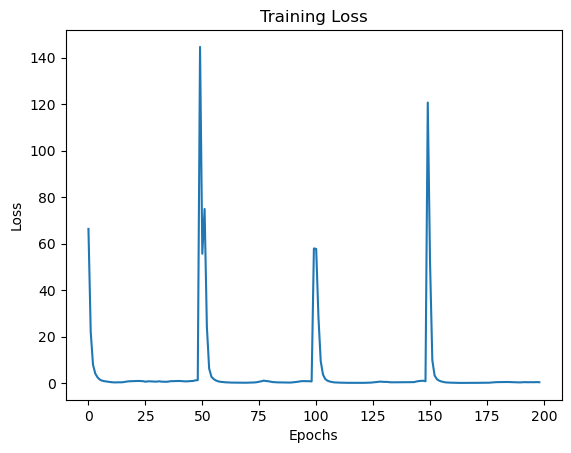

In [112]:
# Plot the loss.
plt.plot(np.arange(len(losses[1:])),losses[1:])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Testing of Model.

Load the presaved model.

In [15]:
# model = torch.load('smallYOLO_model.pth', map_location=torch.device('cpu'))
model = torch.load('smallYOLO_model.pth', map_location=torch.device('cuda'))

### Output on testing Data.

In [17]:
def get_predictions(model, dataloader):
  predictions = np.empty((0,8))
  actuals = np.empty((0,8))

  model.eval()
  with torch.no_grad():
    for batch in dataloader:
      images, labels = batch
      images = images.to(device)
      output = model(images)
      predictions = np.vstack((predictions, output.cpu().numpy()))
      actuals = np.vstack((actuals,labels.numpy()))

  return predictions, actuals

def get_mAP(predictions, actuals): ## Return mAP@0.5:0.95:0.05
    APs = [get_AP(predictions, actuals, iou_threshold/100) for iou_threshold in range(50, 100, 5)]
    return np.mean(APs)

def get_f1_score(predictions, actuals):
    idx_obj = np.where(actuals[:,3] == 1)[0]
    class_pred = np.argmax(predictions[idx_obj,:3], axis = 1)
    class_actual = np.argmax(actuals[idx_obj,:3], axis = 1)
    f1 = f1_score(class_actual, class_pred, average='weighted')
    return f1

def get_AP(predictions, actuals, iou_threshold):

    sorted_indices = np.argsort(predictions[:,3])[::-1]
    predictions_sorted = predictions[sorted_indices]
    actuals_sorted = actuals[sorted_indices]

    TP = np.zeros(predictions_sorted.shape[0])
    FP = np.zeros(predictions_sorted.shape[0])
    FN = np.zeros(predictions_sorted.shape[0])
    TN = np.zeros(predictions_sorted.shape[0])

    for i in range(predictions_sorted.shape[0]): ## Go to all the predictions.
        if (predictions_sorted[i,3] > 0.5) and (actuals_sorted[i,3]==1): ## If there was actually an object.
            ## Also Check class here.
            if np.argmax(predictions_sorted[i,0:3]) == np.argmax(actuals_sorted[i,0:3]): ## If the class was correctly predicted.
                iou = get_iou(predictions_sorted[i,4:], actuals_sorted[i,4:])
                if iou > iou_threshold:
                    TP[i] = 1
                else:
                    FP[i] = 1
            else:
                FP[i] = 1
        elif (predictions_sorted[i,3] > 0.5) and (actuals_sorted[i,3]==0): ## If there was no object but was predicted.
            FP[i] = 1
        elif (predictions_sorted[i,3] <= 0.5) and (actuals_sorted[i,3]==1): ## If there was object but was not predicted.
            FN[i] = 1
        else: ## If there was no object and was not predicted.
            TN[i] = 1

    ## Calculate Precision, Recall and F1 Score.
    TP_cumsum = np.cumsum(TP)
    FP_cumsum = np.cumsum(FP)
    FN_cumsum = np.cumsum(FN)

    delta = 1e-7
    total_true_bbx = TP_cumsum[-1] + FN_cumsum[-1]
    precision = TP_cumsum/(TP_cumsum + FP_cumsum + delta)
    recall = TP_cumsum/(total_true_bbx + delta)
    precision = np.concatenate(([1], precision))
    recall = np.concatenate(([0], recall))
    average_precision = np.trapz(precision, recall)

    return average_precision

def get_iou(bb1, bb2):
    bb1 = [bb1[0], bb1[1], bb1[0]+bb1[2], bb1[1]+bb1[3]]
    bb2 = [bb2[0], bb2[1], bb2[0]+bb2[2], bb2[1]+bb2[3]]
    x1 = max(bb1[0], bb2[0])
    y1 = max(bb1[1], bb2[1])
    x2 = min(bb1[2], bb2[2])
    y2 = min(bb1[3], bb2[3])

    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    area_bb1 = (bb1[2] - bb1[0] + 1) * (bb1[3] - bb1[1] + 1)
    area_bb2 = (bb2[2] - bb2[0] + 1) * (bb2[3] - bb2[1] + 1)
    union_area = area_bb1 + area_bb2 - intersection_area

    return intersection_area/union_area

def get_detection_accuracy(predictions, actuals): ## Accuracy in detection of Hand or Not.
    obj_pred = np.where(predictions[:,3] > 0.5, 1, 0)
    obj_actual = actuals[:,3]
    obj_accuracy = np.sum(obj_pred == obj_actual)/len(obj_actual)
    return obj_accuracy

def get_classification_accuracy(predictions, actuals): ## Accuracy in classification of Hand Gestures.
    ## Confusion Matrix for class prediction.
    idx_obj = np.where(actuals[:,3] == 1)[0]
    class_pred = np.argmax(predictions[idx_obj,:3], axis = 1)
    class_actual = np.argmax(actuals[idx_obj,:3], axis = 1)
    class_accuracy = np.sum(class_pred == class_actual)/len(class_actual)
    return class_accuracy

def plot_confusion_matrix(predictions, actuals, dataname): ## Accuracy in classification of Hand Gestures.
    ## Confusion Matrix for class prediction.
    ## Get subset of data when there is a object in frame.
    idx_obj = np.where(actuals[:,3] == 1)[0]
    class_pred = np.argmax(predictions[idx_obj,:3], axis = 1)
    class_actual = np.argmax(actuals[idx_obj,:3], axis = 1)

    cm = confusion_matrix(class_actual, class_pred)

    class_accuracy = np.trace(cm)/np.sum(cm)

    # Plot confusion matrix
    # plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Conf. Mat. {} data, Acc: {:.2f}%".format(dataname,class_accuracy*100))

def get_mean_iou(predictions, actuals):
    idx_obj = np.where(actuals[:,3] == 1)[0]
    ious = [get_iou(predictions[i,4:], actuals[i,4:]) for i in idx_obj]
    return np.mean(ious)

In [18]:
### Quantitative Evaluation.
## On Train Data.
train_predictions, train_actuals = get_predictions(model, train_dataloader_1)

train_mAP = get_mAP(train_predictions, train_actuals)
train_mean_iou = get_mean_iou(train_predictions, train_actuals)
train_classification_accuracy = get_classification_accuracy(train_predictions, train_actuals)
train_detection_accuracy = get_detection_accuracy(train_predictions, train_actuals)
train_f1_score = get_f1_score(train_predictions, train_actuals)

## On Validation Data.
val_predictions, val_actuals = get_predictions(model, val_dataloader)

val_mAP = get_mAP(val_predictions, val_actuals)
val_mean_iou = get_mean_iou(val_predictions, val_actuals)
val_classification_accuracy = get_classification_accuracy(val_predictions, val_actuals)
val_detection_accuracy = get_detection_accuracy(val_predictions, val_actuals)
val_f1_score = get_f1_score(val_predictions, val_actuals)

## On Test Data.
test_predictions, test_actuals = get_predictions(model, test_dataloader)

test_mAP = get_mAP(test_predictions, test_actuals)
test_mean_iou = get_mean_iou(test_predictions, test_actuals)
test_classification_accuracy = get_classification_accuracy(test_predictions, test_actuals)
test_detection_accuracy = get_detection_accuracy(test_predictions, test_actuals)
test_f1_score = get_f1_score(test_predictions, test_actuals)

# table = [['Train', train_mAP * 100, train_mean_iou * 100, train_classification_accuracy * 100, train_detection_accuracy * 100, train_f1_score],
#          ['Validation', val_mAP * 100, val_mean_iou * 100, val_classification_accuracy * 100, val_detection_accuracy * 100, val_f1_score],
#          ['Test', test_mAP * 100, test_mean_iou * 100, test_classification_accuracy * 100, test_detection_accuracy * 100, test_f1_score]]

table = [['Train', train_mAP * 100,   train_f1_score],
         ['Validation', val_mAP * 100, val_f1_score],
         ['Test', test_mAP * 100, test_f1_score]]

# print(tabulate(table, headers=['Data', 'mAP*100', 'Mean IoU*100', 'Classification Accuracy %', 'Detection Accuracy %', 'F1 Score'],
#                 tablefmt='orgtbl',
#                 colalign=("center", "center", "center", "center", "center", "center")))

print(tabulate(table, headers=['Data', 'mAP*100', 'F1 Score'],
                tablefmt='orgtbl',
                colalign=("center", "center", "center")))

|    Data    |  mAP*100  |  F1 Score  |
|------------+-----------+------------|
|   Train    |  92.8316  |     1      |
| Validation |  85.2106  |  0.973055  |
|    Test    |  85.9546  |  0.968676  |


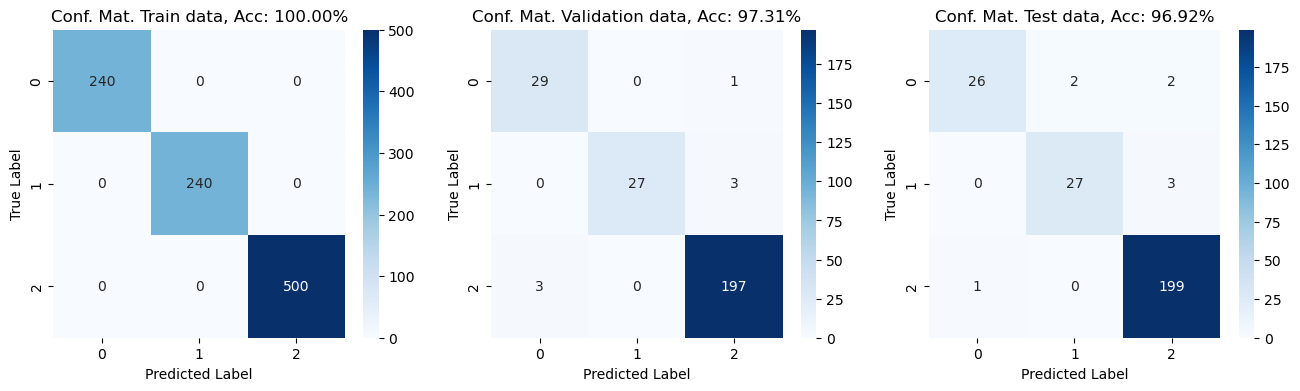

In [34]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plot_confusion_matrix(train_predictions, train_actuals,'Train')

plt.subplot(1, 3, 2)
plot_confusion_matrix(val_predictions, val_actuals,'Validation')

plt.subplot(1, 3, 3)
plot_confusion_matrix(test_predictions, test_actuals,'Test')

plt.show()

### Qualitative results.

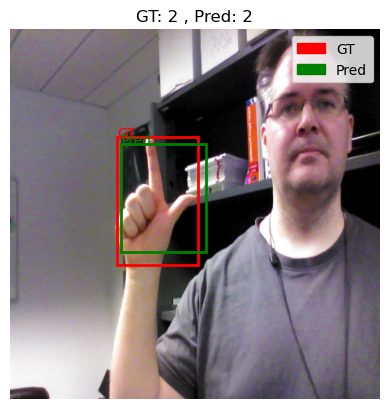

In [51]:
## Visualization of results.
model.eval()
for batch in test_dataloader:
    images, labels = batch
    for i in range(1):
        with torch.no_grad(): ## This helps in not having a backprob layer.
          images = images.to(device)
          prediction = model(images[i].unsqueeze(0)).to('cpu').numpy()
        plt.imshow(images[i].to('cpu').permute(1, 2, 0))
        labels[:,4:] = labels[:,4:]*images[i].shape[1]
        prediction[:,4:] = prediction[:,4:]*images[i].shape[1]
        if labels[i][3] > 0.5:
          plt.title(f'GT: {torch.argmax(labels[i][:3]).item()} , Pred: {np.argmax(prediction[i][:3])}')
          plt.gca().add_patch(plt.Rectangle((labels[i][4], labels[i][5]), labels[i][6], labels[i][7], linewidth=2,
                                      edgecolor='r', facecolor='none'))  # Add bounding box to the plot
          plt.text(labels[i][4], labels[i][5], 'GT', color='r')
        if prediction[0][3] > 0.5:
          plt.gca().add_patch(plt.Rectangle((prediction[0][4], prediction[0][5]), prediction[0][6], prediction[0][7], linewidth=2,
                                      edgecolor='g', facecolor='none'))  # Add bounding box to the plot
          plt.text(prediction[0][4], prediction[0][5], f'Pred', color='g')
        plt.legend(handles=[patches.Patch(color='r', label='GT'), patches.Patch(color='g', label='Pred')])
        plt.axis('off')
        plt.show()
    break